# **Import Statements**

In [37]:
import itertools

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import spacy
import functools
import re

# from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
# from sklearn import model_selection, naive_bayes, svm


import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE #OVERAMPLING
from sklearn.model_selection import KFold, StratifiedKFold
# from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel
from scipy.special import softmax
%matplotlib inline

In [40]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [41]:
# !nvcc --version
# NEED TO RUN THIS FOR SVM WITH GPU USAGE
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
!pip install thundersvm

--2023-03-26 16:11:40--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.39.144
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2023-03-26 16:11:41--  https://developer.nvidia.com/downloads/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?EKHXShyvWf4wa3em2ZHISSE3f1ytyrLuz6UGslaN27GiC-ljdKJveYN6EDefs33RzST32Huip

In [42]:
!nvidia-smi

Sun Mar 26 16:12:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |    541MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.decomposition import TruncatedSVD
import thundersvm



# **Function Definitions**

**Data Preprocessing** 

In [44]:
def build_dataframe(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(line.strip().split('\t'))
    df = pd.DataFrame(data)
    return df

def check_affixes(token, lemma):
    prefixes = [ "dis", "ir", "im", "in", "a", "il", "non", "un", "ig", "mis", "anti", "ab", "an"]
    is_lemma_without = 2
    if any(token.lower().startswith(prefix) for prefix in prefixes):
      prefix = set(token.lower()).intersection(prefixes)
      if token != 'in' or token!= 'a' or token != 'an': #chekcing special case   
        start = len(prefix)+1
        end = len(token) 
        if token[start:end].startswith(lemma, 0, len(lemma)):
          is_lemma_without = 1
        else:
          is_lemma_without = 0
        return 1, is_lemma_without
    elif token.lower().endswith("less"):
      if token[0:len(token)-4].startswith(lemma, len(lemma)):
        is_lemma_without = 1
      else:
        is_lemma_without = 0
      return 1, is_lemma_without
    return 0, is_lemma_without

def set_features_values(row,spacy_tokenized,idx):
    
    #full sentence
    row['sentence']       = ' '.join([token.text for token in spacy_tokenized])
    try:
      row['next_token']     = spacy_tokenized[idx+1].text 
    except IndexError:
      row['next_token'] = ""
    row['prev_token']     = spacy_tokenized[idx-1].text if idx > 0 else ""
    #Lemma
    row['lemma']          = spacy_tokenized[idx].lemma_ 
    try:
      row['next_lemma']     = spacy_tokenized[idx+1].lemma_ 
    except IndexError:
      row['next_lemma'] = ""
    row['prev_lemma']     = spacy_tokenized[idx-1].lemma_ if idx > 0 else ""
    row['double_prev_lemma'] = spacy_tokenized[idx-2].lemma_ if idx > 0 else ""

    # Dependency Parser
    row['tag']          = spacy_tokenized[idx].tag_
    row['dependency']   = spacy_tokenized[idx].dep_
    row['head']         = spacy_tokenized[idx].head.text
    row['root_path']    = len(list(spacy_tokenized[idx].ancestors))    

    # Negative Expression List
    NegExpList = ['nor', 'neither', 'without', 'nobody', 'none', 'nothing', 'never', 'not', 'no', 'nowhere', 'non']
    token = spacy_tokenized[idx].text.lower()
    if  token in NegExpList:
      neg = 1
    else:
      neg = 0
    row['neg_exp_list'] = neg
    #Check negative affixes
    bol, is_lemma = check_affixes(spacy_tokenized[idx].text, spacy_tokenized[idx].lemma_)
    row['affix_cue'] = bol
    row['is_lemma_without_affix'] = is_lemma

    return row

In [45]:
def add_token_features(df,spacy_tokenized,offset=1):
    """
    (TODO move this description) Add features from spacy dependency parse. In case tokenizations from spacy and database don't match, for each word we look in the neighborhood for the token,
    usually it's shifted 1 position. In case tokenizations doesn't match and we dont find the token in the neighborhood, those features are set to None in that row
    Params:
        -offset: number of tokens to the left and right to look in case tokenizations doesn't match
    """
    i=0
    for idx,row in df.iterrows():
        
        # Both tokenizarions match:
        if row['token'] == spacy_tokenized[i].text:

            row = set_features_values(row,spacy_tokenized,i)
        else:

            if row['token'] == spacy_tokenized[i-offset].text:
                row = set_features_values(row,spacy_tokenized,i-offset)
            elif row['token'] == spacy_tokenized[i+offset].text:
                row = set_features_values(row,spacy_tokenized,i+offset)
            else:
                #try one position more
                
                if row['token'] == spacy_tokenized[i-offset+1].text:
                    row = set_features_values(row,spacy_tokenized,i-offset+1)
                elif row['token'] == spacy_tokenized[i+offset+1].text:
                    row = set_features_values(row,spacy_tokenized,i+offset+1)                

        i += 1
    
    # print(f"new df: \n{df[['token', 'tag', 'dependency', 'head', 'root_path']]}")
    return df
    # spacy.displacy.serve(spacy_tokenized, style="dep")    

def applySentenceGroupBy(sentence_df):

    tokens = []
    for i,row in sentence_df.iterrows():
        tokens.append(row['token'])
    
    #reconstruct string from original df
    string = ' '.join([token for token in tokens])
    
    #use spacy to tokenize and extract dependencies, etc.
    spacy_tokenized = nlp(string)
    
    sentence_df = add_token_features(sentence_df,spacy_tokenized,offset=1)    

    return sentence_df


# df

**Ablation**

In [46]:
from sklearn.base import BaseEstimator,TransformerMixin

class custom_tfidf(BaseEstimator,TransformerMixin):
    def __init__(self,tfidf):
        self.tfidf = tfidf

    def fit(self, X, y=None):
        joined_X = X.apply(lambda x: ' '.join(x), axis=1)
        self.tfidf.fit(joined_X)        
        return self

    def transform(self, X):
        joined_X = X.apply(lambda x: ' '.join(x), axis=1)

        return self.tfidf.transform(joined_X)  

In [47]:
accuracy_score,
def grid_and_select(x_tr, y_tr, x_te, y_te, features):
  num = StandardScaler()      
  vectorizer1 = TfidfVectorizer()#.fit(corpus_df.text.to_list())

  numeric_transformer  = Pipeline(
  steps=[("scaler", StandardScaler())])
  str_transformer = Pipeline(
  steps=[
        ("tfidf", custom_tfidf(vectorizer1))
    ]) 

  features_numeric_control = ['root_path',
                                'neg_exp_list',
                                'affix_cue',
                              'is_lemma_without_affix']
  feature_str_control =      ['next_token', 'prev_token'
                                'token', 'next_lemma'
                                'double_prev_lemma'
                                'prev_lemma',
                                'lemma',
                                'tag',
                                'dependency',
                                'head']


    
  feature_str = [feat for feat in features if feat in feature_str_control]
  features_numeric = [feat for feat in features if feat in features_numeric_control]



  preprocessor = ColumnTransformer(
        transformers=[('tfidf', str_transformer, feature_str),
                      ('num',numeric_transformer,features_numeric)  
                      ])
  pipe_svm = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', thundersvm.SVC())])
        
        # SVM
  param_grid_svm = {
            'classifier__C':      [1.0, 10.0],
            'classifier__kernel': ['linear'],
            'classifier__gamma':  [0.5, 1],
        }

  grid_svm     = GridSearchCV(pipe_svm, param_grid_svm, n_jobs=1, cv=2)

  pipe_xgb = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', xgb.XGBClassifier(tree_method='gpu_hist'))])
        
        # XGB
  param_grid_xgb = {
            'classifier__max_depth':        [5],
            'classifier__colsample_bytree': [0.6, 1.0],
            'classifier__learning_rate':    [0.1, 0.3],
        }

  grid_xgb     = GridSearchCV(pipe_xgb, param_grid_xgb, n_jobs=1, cv=2)
  
  grid_svm.fit(x_tr,y_tr)
  y_pred = grid_svm.predict(x_te)
  a_svm = round(accuracy_score(y_te, y_pred),3)
  rep_svm = classification_report(y_te, y_pred, output_dict = True)
  macro_avg_f1_svm = rep_svm['macro avg']['f1-score']
  results_svm = [a_svm, macro_avg_f1_svm]
  params_svm = grid_svm.best_params_

  grid_xgb.fit(x_tr,y_tr)
  y_pred = grid_xgb.predict(x_te)
  a_xgb = accuracy_score(y_te, y_pred)
  rep_xgb = classification_report(y_te, y_pred, output_dict = True)
  macro_avg_f1_xgb = rep_svm['macro avg']['f1-score']
  results_xgb = [a_xgb, macro_avg_f1_xgb]
  params_xgb = grid_xgb.best_params_

  return params_svm, params_xgb, results_svm, results_xgb



In [48]:
def ablation(combination_features, basic_features):
  acs_svm = []
  acs_xgb = []
  maf1_svm = []
  maf1_xgb = []
  p_svm = []
  p_xgb = []
 
  for combination in combination_features:
    #transform list of tuples to list of lists
    actual_combination = combination + basic_features
   
      
      #  False
    x_tra = x_abl_tr[actual_combination].copy()
    x_tes = x_abl_te[actual_combination].copy()

    param_svm, param_xgb, result_svm, result_xgb = grid_and_select(x_tra, y_abl_tr, x_tes,y_abl_te, actual_combination)
    acs_svm.append(result_svm[0])
    acs_xgb.append(result_xgb[0])
    maf1_svm.append(result_svm[1])
    maf1_xgb.append(result_xgb[1])
    p_svm.append(param_svm)
    p_xgb.append(param_xgb)
    del x_tra
    del actual_combination
    del x_tes
  list_of_tuples = list(zip(combination_features, acs_svm,maf1_svm, p_svm, acs_xgb, maf1_xgb, p_xgb))
  results = pd.DataFrame(list_of_tuples, columns = ['Feature_set', 'A SVM', 'MA F1 SVM', 'pars SVM', 'A XGB', 'MA F1 XGB', 'pars XGB'])
  return results

# **Data PreProcessing**

In [49]:
nlp = spacy.load("en_core_web_sm")

df = build_dataframe("/content/SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt")
df = df.rename(columns={0: 'file', 1: 'nSentence', 2: 'nToken', 3: 'token', 4: 'negCue'})

df.insert(0, 'sentence', None)
df.insert(len(df.columns)-1, 'next_token', None)
df.insert(len(df.columns)-1, 'prev_token', None)
df.insert(len(df.columns)-1, 'lemma', None)
df.insert(len(df.columns)-1, 'next_lemma', None)
df.insert(len(df.columns)-1, 'prev_lemma', None)
df.insert(len(df.columns)-1, 'double_prev_lemma', None)
df.insert(len(df.columns)-1, 'tag', None)
df.insert(len(df.columns)-1, 'dependency', None)
df.insert(len(df.columns)-1, 'head', None)
df.insert(len(df.columns)-1, 'root_path', None)
df.insert(len(df.columns)-1, 'neg_exp_list', None)
df.insert(len(df.columns)-1, 'affix_cue', None)
df.insert(len(df.columns)-1, 'is_lemma_without_affix', None)
# 

# df

In [50]:
column_names = df.columns
new_df = pd.DataFrame(columns=column_names)

for _file in df.file.unique():
    file_df = df[df['file']==_file]

    file_df = file_df.groupby(['nSentence']).apply(applySentenceGroupBy)

    # print(file_df[['token', 'tag', 'dependency', 'head', 'root_path']].head(50))
    new_df = new_df.append(file_df)
    # break

df = new_df

#new_df[(new_df['affix_cue'] == True) & (new_df['negCue']=='B-NEG')]

#Encode golden label
negCue_dict = {"negCue":     {"O": 0, "B-NEG": 1, "I-NEG": 2}}
df = df.replace(negCue_dict)

# df

In [51]:
test_df_1 = build_dataframe("/content/SEM-2012-SharedTask-CD-SCO-test-cardboard.txt")
test_df_2 = build_dataframe("/content/SEM-2012-SharedTask-CD-SCO-test-circle.txt")
test_df_1 = test_df_1.rename(columns={0: 'file', 1: 'nSentence', 2: 'nToken', 3: 'token', 4: 'negCue'})
test_df_2 = test_df_2.rename(columns={0: 'file', 1: 'nSentence', 2: 'nToken', 3: 'token', 4: 'negCue'})

test_df_1.insert(0, 'sentence', None)
test_df_1.insert(len(test_df_1.columns)-1, 'lemma', None)
test_df_1.insert(len(test_df_1.columns)-1, 'next_lemma', None)
test_df_1.insert(len(test_df_1.columns)-1, 'prev_lemma', None)
test_df_1.insert(len(test_df_1.columns)-1, 'next_token', None)
test_df_1.insert(len(test_df_1.columns)-1, 'prev_token', None)
test_df_1.insert(len(test_df_1.columns)-1, 'double_prev_lemma', None)
test_df_1.insert(len(test_df_1.columns)-1, 'tag', None)
test_df_1.insert(len(test_df_1.columns)-1, 'dependency', None)
test_df_1.insert(len(test_df_1.columns)-1, 'head', None)
test_df_1.insert(len(test_df_1.columns)-1, 'root_path', None)
test_df_1.insert(len(test_df_1.columns)-1, 'neg_exp_list', None)
test_df_1.insert(len(test_df_1.columns)-1, 'affix_cue', None)
test_df_1.insert(len(test_df_1.columns)-1, 'is_lemma_without_affix', None)

test_df_2.insert(0, 'sentence', None)
test_df_2.insert(len(test_df_2.columns)-1, 'lemma', None)
test_df_2.insert(len(test_df_2.columns)-1, 'next_lemma', None)
test_df_2.insert(len(test_df_2.columns)-1, 'prev_lemma', None)
test_df_2.insert(len(test_df_2.columns)-1, 'next_token', None)
test_df_2.insert(len(test_df_2.columns)-1, 'prev_token', None)
test_df_2.insert(len(test_df_2.columns)-1, 'double_prev_lemma', None)
test_df_2.insert(len(test_df_2.columns)-1, 'tag', None)
test_df_2.insert(len(test_df_2.columns)-1, 'dependency', None)
test_df_2.insert(len(test_df_2.columns)-1, 'head', None)
test_df_2.insert(len(test_df_2.columns)-1, 'root_path', None)
test_df_2.insert(len(test_df_2.columns)-1, 'neg_exp_list', None)
test_df_2.insert(len(test_df_2.columns)-1, 'affix_cue', None)
test_df_2.insert(len(test_df_2.columns)-1, 'is_lemma_without_affix', None)

In [52]:
test_column_names = test_df_1.columns
new_df = pd.DataFrame(columns=test_column_names)

for _file in test_df_1.file.unique():
    file_df = test_df_1[test_df_1['file']==_file]
    file_df = file_df.groupby(['nSentence']).apply(applySentenceGroupBy)
    new_df = new_df.append(file_df)
test_df_1 = new_df

new_df = pd.DataFrame(columns=test_column_names)
for _file in test_df_2.file.unique():
    file_df = test_df_2[test_df_2['file']==_file]
    file_df = file_df.groupby(['nSentence']).apply(applySentenceGroupBy)
    new_df = new_df.append(file_df)

test_df_2 = new_df

#Encode golden label
negCue_dict = {"negCue":     {"O": 0, "B-NEG": 1, "I-NEG": 2}}
test_df_1 = test_df_2.replace(negCue_dict).dropna() ##drop na!! 
test_df_2 = test_df_2.replace(negCue_dict).dropna() ##drop na!! 

In [53]:
dev_df = build_dataframe("/content/SEM-2012-SharedTask-CD-SCO-dev-simple.v2.txt")
dev_df = dev_df.rename(columns={0: 'file', 1: 'nSentence', 2: 'nToken', 3: 'token', 4: 'negCue'})

dev_df.insert(0, 'sentence', None)
dev_df.insert(len(dev_df.columns)-1, 'lemma', None)
dev_df.insert(len(dev_df.columns)-1, 'next_lemma', None)
dev_df.insert(len(dev_df.columns)-1, 'prev_lemma', None)
dev_df.insert(len(dev_df.columns)-1, 'next_token', None)
dev_df.insert(len(dev_df.columns)-1, 'prev_token', None)
dev_df.insert(len(dev_df.columns)-1, 'double_prev_lemma', None)
dev_df.insert(len(dev_df.columns)-1, 'tag', None)
dev_df.insert(len(dev_df.columns)-1, 'dependency', None)
dev_df.insert(len(dev_df.columns)-1, 'head', None)
dev_df.insert(len(dev_df.columns)-1, 'root_path', None)
dev_df.insert(len(dev_df.columns)-1, 'neg_exp_list', None)
dev_df.insert(len(dev_df.columns)-1, 'affix_cue', None)
dev_df.insert(len(dev_df.columns)-1, 'is_lemma_without_affix', None)


dev_column_names = dev_df.columns
new_df = pd.DataFrame(columns=column_names)

for _file in dev_df.file.unique():
    file_df = dev_df[dev_df['file']==_file]
    file_df = file_df.groupby(['nSentence']).apply(applySentenceGroupBy)
    new_df = new_df.append(file_df)

dev_df = new_df

#Encode golden label
negCue_dict = {"negCue":     {"O": 0, "B-NEG": 1, "I-NEG": 2}}
dev_df = dev_df.replace(negCue_dict).dropna() ##drop na!! 

In [54]:
aux_df = df.drop(columns=['file',]).dropna()
y_dev = dev_df['negCue']
y_test1 = test_df_1['negCue']
y_test2 = test_df_2['negCue']

aux_dev_df = dev_df.drop(columns=['negCue'])
aux_test1_df = test_df_1.drop(columns=['negCue'])
aux_test2_df = test_df_1.drop(columns=['negCue'])

aux_X = aux_df.drop(columns = ['negCue'])
aux_y = aux_df['negCue']
print(len(aux_y))
aux_X_ = aux_X.copy()

63039


# **Histograms**

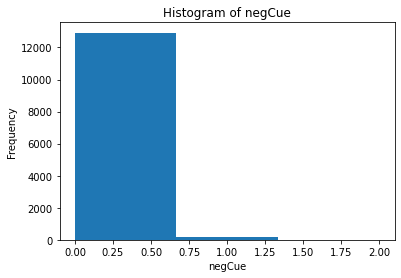

0    12921
1      172
2        3
Name: negCue, dtype: int64


In [55]:
plt.hist(dev_df['negCue'], bins=3)

# Add labels
plt.xlabel('negCue')
plt.ylabel('Frequency')
plt.title('Histogram of negCue')

# Show plot
plt.show()
print(dev_df['negCue'].value_counts())

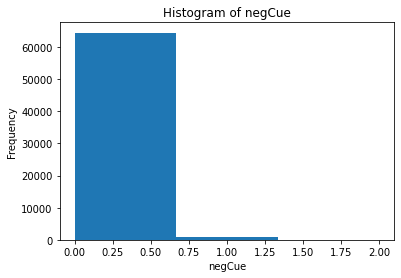

0    64448
1      987
2       16
Name: negCue, dtype: int64


In [56]:
# Plot histogram
plt.hist(df['negCue'], bins=3)

# Add labels
plt.xlabel('negCue')
plt.ylabel('Frequency')
plt.title('Histogram of negCue')

# Show plot
plt.show()
print(df['negCue'].value_counts())

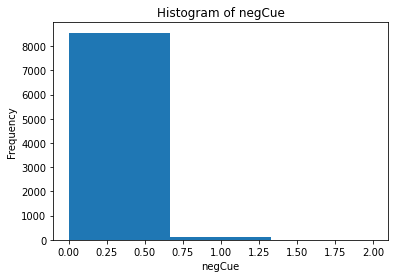

0    64448
1      987
2       16
Name: negCue, dtype: int64


In [57]:
# Plot histogram
plt.hist(test_df_1['negCue'], bins=3)

# Add labels
plt.xlabel('negCue')
plt.ylabel('Frequency')
plt.title('Histogram of negCue')

# Show plot
plt.show()
print(df['negCue'].value_counts())

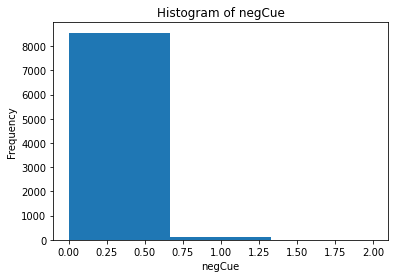

0    64448
1      987
2       16
Name: negCue, dtype: int64


In [58]:
# Plot histogram
plt.hist(test_df_2['negCue'], bins=3)

# Add labels
plt.xlabel('negCue')
plt.ylabel('Frequency')
plt.title('Histogram of negCue')

# Show plot
plt.show()
print(df['negCue'].value_counts())

# **Ablation Study**

In [59]:
full_feature_set =  {'tag','double_prev_lemma','dependency','head','root_path','is_lemma_without_affix'}
features = ['token','lemma','next_lemma','prev_lemma', 'double_prev_lemma','tag','dependency','prev_token', 'next_token','head','root_path','neg_exp_list','affix_cue', 'is_lemma_without_affix']
basic_set = ['token', 'lemma', 'prev_lemma','next_lemma', 'prev_token', 'next_token', 'neg_exp_list', 'affix_cue']

In [60]:
X_train = aux_X_[features].copy()
X_test1 = aux_test1_df[features].copy()
X_test2 = aux_test2_df[features].copy()
X_dev   = aux_dev_df[features].copy()
x_abl_tr, x_abl_te, y_abl_tr, y_abl_te =  train_test_split(X_dev, y_dev, random_state=73, test_size=(1/3), stratify=y_dev)
print(x_abl_te)

          token    lemma next_lemma prev_lemma double_prev_lemma  tag  \
3707       from     from        his       mile                 a   IN   
9634      first    first        day         my                 .   JJ   
12212      safe     safe          .         go           monster   JJ   
2217    evening  evening          I        the                of   NN   
2909         at       at      whose          ,          Melville   IN   
...         ...      ...        ...        ...               ...  ...   
12255  blanched   blanch       with       face              worn  VBN   
8267      found     find       dead         be                 ,  VBN   
2331        the      the    content         to                as   DT   
9360       were       be        all       they                 .  VBD   
5743          ,        ,         my       well                 `    ,   

      dependency prev_token next_token        head root_path neg_exp_list  \
3707        prep       mile        his       f

In [61]:
all_combinations = []
for i in range(0,7):
  combination = list(itertools.combinations(full_feature_set , i))
  #print(combination)
  combo = list(map(list, combination))
  all_combinations += combo
#print(all_combinations[17]+basic_set)

In [62]:
results_of_ablation = ablation(all_combinations, basic_set)
print(results_of_ablation)

                                          Feature_set  A SVM  MA F1 SVM  \
0                                                  []  0.994   0.577944   
1                                         [root_path]  0.994   0.577944   
2                            [is_lemma_without_affix]  0.994   0.577944   
3                                              [head]  0.994   0.577944   
4                                               [tag]  0.995   0.586702   
..                                                ...    ...        ...   
59  [root_path, is_lemma_without_affix, head, doub...  0.994   0.577944   
60  [root_path, is_lemma_without_affix, tag, doubl...  0.995   0.597829   
61  [root_path, head, tag, double_prev_lemma, depe...  0.994   0.584756   
62  [is_lemma_without_affix, head, tag, double_pre...  0.995   0.589832   
63  [root_path, is_lemma_without_affix, head, tag,...  0.994   0.584756   

                                             pars SVM     A XGB  MA F1 XGB  \
0   {'classifier__C':

In [63]:
print(results_of_ablation['MA F1 SVM'])
print(max(results_of_ablation['MA F1 SVM']))
print(results_of_ablation['MA F1 XGB'])
print(max(results_of_ablation['MA F1 XGB']))

0     0.577944
1     0.577944
2     0.577944
3     0.577944
4     0.586702
        ...   
59    0.577944
60    0.597829
61    0.584756
62    0.589832
63    0.584756
Name: MA F1 SVM, Length: 64, dtype: float64
0.6220617992890348
0     0.577944
1     0.577944
2     0.577944
3     0.577944
4     0.586702
        ...   
59    0.577944
60    0.597829
61    0.584756
62    0.589832
63    0.584756
Name: MA F1 XGB, Length: 64, dtype: float64
0.6220617992890348


In [64]:
ind_svm = results_of_ablation['MA F1 SVM'].idxmax()
ind_xgb = results_of_ablation['MA F1 XGB'].idxmax()

print(results_of_ablation.iloc[ind_svm])
print(results_of_ablation.iloc[ind_xgb])

Feature_set                              [root_path, dependency]
A SVM                                                      0.997
MA F1 SVM                                               0.622062
pars SVM       {'classifier__C': 1.0, 'classifier__gamma': 0....
A XGB                                                   0.996564
MA F1 XGB                                               0.622062
pars XGB       {'classifier__colsample_bytree': 1.0, 'classif...
Name: 11, dtype: object
Feature_set                              [root_path, dependency]
A SVM                                                      0.997
MA F1 SVM                                               0.622062
pars SVM       {'classifier__C': 1.0, 'classifier__gamma': 0....
A XGB                                                   0.996564
MA F1 XGB                                               0.622062
pars XGB       {'classifier__colsample_bytree': 1.0, 'classif...
Name: 11, dtype: object


# **Training**

In [97]:
num = StandardScaler()      
vectorizer1 = TfidfVectorizer()#.fit(corpus_df.text.to_list())

numeric_transformer  = Pipeline(
  steps=[("scaler", StandardScaler())])
str_transformer = Pipeline(
  steps=[
        ("tfidf", custom_tfidf(vectorizer1))
    ]) 

features_numeric_control = ['root_path',
                                'neg_exp_list',
                                'affix_cue']
feature_str_control =      ['next_token', 'prev_token'
                                'token', 'next_lemma'
                                'double_prev_lemma'
                                'prev_lemma',
                                'lemma',
                                'dependency',]


    
feature_str = [feat for feat in features if feat in feature_str_control]
features_numeric = [feat for feat in features if feat in features_numeric_control]



preprocessor = ColumnTransformer(
        transformers=[('tfidf', str_transformer, feature_str),
                      ('num',numeric_transformer,features_numeric)  
                      ])
pipe_svm = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', thundersvm.SVC())])
        
        # SVM
param_grid_svm = {
            'classifier__C':      [1.0, 10.0],
            'classifier__kernel': ['linear'],
            'classifier__gamma':  [0.5, 1],
        }

grid_svm     = GridSearchCV(pipe_svm, param_grid_svm, n_jobs=1, cv=2)

pipe_xgb = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', xgb.XGBClassifier(tree_method='gpu_hist'))])
        
        # XGB
param_grid_xgb = {
            'classifier__max_depth':        [5],
            'classifier__colsample_bytree': [0.6, 1.0],
            'classifier__learning_rate':    [0.1, 0.3],
        }

grid_xgb     = GridSearchCV(pipe_xgb, param_grid_xgb, n_jobs=1, cv=2)



In [107]:
#Get results on first test set
#first test set 
grid_svm.fit(X_train[feature_set], aux_y)
y_pred_svm = grid_svm.predict(X_test1)
rep_svm = classification_report(y_test1, y_pred_svm, output_dict = True)
print(rep_svm)

df_svm = X_test1[features].copy()
df_svm['predictions'] = y_pred_svm
df_svm['Golden'] = y_test1
df_svm_errors = df_svm[df_svm['predictions'] != df_svm['Golden']]
df_svm_errors.to_csv('/content/svm_errors_test1.csv')

grid_xgb.fit(X_train[feature_set], aux_y)
y_pred_xgb = grid_xgb.predict(X_test1[feature_set])
rep_xgb = classification_report(y_test1, y_pred_xgb, output_dict = True)
print(rep_xgb)

df_xgb = X_test1[features].copy()
df_xgb['predictions'] = y_pred_xgb
df_xgb['Golden'] = y_test1
df_xgb_errors = df_xgb[df_svm['predictions'] != df_xgb['Golden']]
df_xgb_errors.to_csv('/content/xgb_errors_test1.csv')

{'0': {'precision': 0.9985974754558204, 'recall': 0.9981308411214953, 'f1-score': 0.9983641037625614, 'support': 8560}, '1': {'precision': 0.8785714285714286, 'recall': 0.9318181818181818, 'f1-score': 0.9044117647058825, 'support': 132}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'accuracy': 0.9966651333946642, 'macro avg': {'precision': 0.625722968009083, 'recall': 0.6433163409798923, 'f1-score': 0.6342586228228146, 'support': 8696}, 'weighted avg': {'precision': 0.996316216475765, 'recall': 0.9966651333946642, 'f1-score': 0.9964787351826934, 'support': 8696}}
{'0': {'precision': 0.9978989144391269, 'recall': 0.998714953271028, 'f1-score': 0.9983067670928943, 'support': 8560}, '1': {'precision': 0.9069767441860465, 'recall': 0.8863636363636364, 'f1-score': 0.896551724137931, 'support': 132}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'accuracy': 0.9965501379944802, 'macro avg': {'precision': 0.6349585528750578, 'recall': 0.628359

In [108]:
from sklearn import metrics

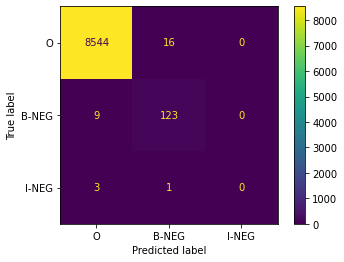

In [109]:
confusion_matrix = metrics.confusion_matrix(y_test1, y_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['O', 'B-NEG', 'I-NEG'])
cm_display.plot()
plt.show()

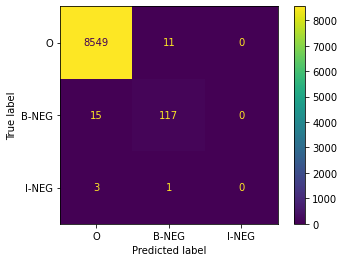

In [110]:
confusion_matrix = metrics.confusion_matrix(y_test1, y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['O', 'B-NEG', 'I-NEG'])
cm_display.plot()
plt.show()

# **Baseline Model (majority)**

In [ ]:
majority_pred_test1 = [0]*len(y_test1)
majority_pred_test2 = [0]*len(y_test2)

In [ ]:
print(classification_report(y_test1, majority_pred_test1, output_dict = True))

{'0': {'precision': 0.984360625574977, 'recall': 1.0, 'f1-score': 0.9921186833565137, 'support': 8560}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 132}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'accuracy': 0.984360625574977, 'macro avg': {'precision': 0.32812020852499235, 'recall': 0.3333333333333333, 'f1-score': 0.33070622778550457, 'support': 8696}, 'weighted avg': {'precision': 0.9689658411823601, 'recall': 0.984360625574977, 'f1-score': 0.9766025677934403, 'support': 8696}}
